## PUMPED HYDRO DISPATCH MODEL (NO DROUGHT)

In [223]:
import cvxpy as cp
import numpy as np
import gurobipy
import pandas as pd
import matplotlib.pyplot as plt

# Print the installed solver to see if GUROBI is installed correctly
print("Current installed solvers: ", cp.installed_solvers())

Current installed solvers:  ['ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [2]:
## Data Load
load_df = pd.read_excel('sw_demand_june.xlsx', sheet_name='demand')
price_df = pd.read_excel('sw_demand_june.xlsx', sheet_name='price')
rad_df = pd.read_excel('sw_demand_june.xlsx', sheet_name='radiation')

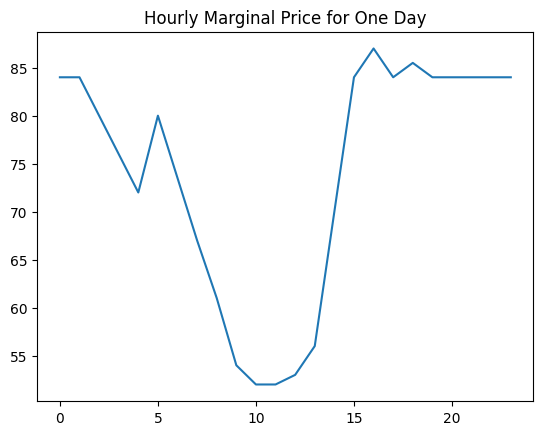

In [3]:
plt.plot(price_df['Marginal Price'])
plt.title('Hourly Marginal Price for One Day')
plt.show()

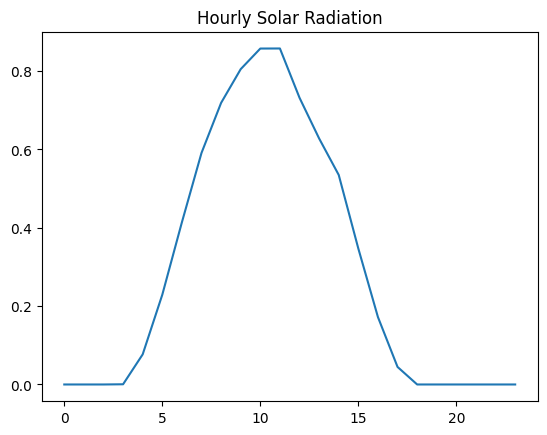

In [4]:
plt.plot(rad_df['July (rescaled)'])
plt.title('Hourly Solar Radiation')
plt.show()

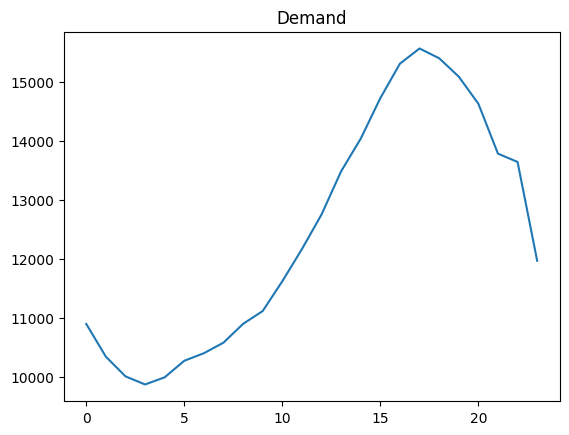

In [5]:
plt.plot(load_df['Demand'][:24])
plt.title('Demand')
plt.show()

## Parameters

In [313]:
T = 24 # number of hours

scale = 10 
# penalty = 100 #penalty for purchasing electricity 

price = np.array(price_df['Marginal Price'])  # price of electricity
alpha = np.array(rad_df['July (rescaled)'])   # solar radiation capacity
LOAD = np.array(load_df['Demand'][:T])/scale

eta = 0.8 # roundtrip efficiency
S = 2000 # solar capacity (MW)
PMax = 1500  # Nameplate capacity (MW)
Emax = 10000 #103950 # Energy storage capacity (MWh) # Note: When we add in adam's formulation this will change to Ac-ft (water)
e0   = Emax/2  # initial reservoir state

## Variables
p = cp.Variable((T), nonneg = True)   # hydropower generation (discharge)
h = cp.Variable((T), nonneg = True)   # hydropower recharge
g = cp.Variable((T), nonneg = True)   # electricity import
x = cp.Variable((T), nonneg = True)   # electricity export
u = cp.Variable((T), boolean = True) # discharge status
v = cp.Variable((T), boolean = True) # charge status
e = cp.Variable((T), nonneg = True)  # upper reservoir state

## Discrete States for Charging and Discharging

$$\max Profit = \sum_{t \in N}\lambda_t(D_t + x_t - g_t)$$
$$g_t + \alpha_tS + p_t = D_t + x_t + h_t$$
$$0 \leq p_t \leq u_tP_{max}$$
$$0 \leq h_t \leq v_t\eta\alpha_tS$$
$$ u_t + v_t = 1 $$
$$0 \leq e_{t} \leq E_{max}$$
$$e_{t} = e_{t-1} + \eta(h_t - p_t)$$ 

In [314]:
obj = cp.Maximize(price@(LOAD + x - g))

# Initialize an empty constraint set
con_set_1 = []  

# power balance constraint, supply equals demand
con_set_1.append(g + S*alpha + p == LOAD + x) 

for t in range(T):  
        con_set_1.append(e[t] <= Emax)  # maximum pumping limits
        con_set_1.append(e[t] >= 0)  # minimum pumping limits
        
        con_set_1.append(p[t] <= u[t]*PMax)  # maximum generation limits
        con_set_1.append(p[t] >= 0)  # minimum generation limits

        con_set_1.append(h[t] <= v[t]*eta*alpha[t]*S)  # maximum pumping limits
        con_set_1.append(h[t] >= 0)  # minimum pumping limits
        
        con_set_1.append(u[t] + v[t] == 1)
        
        if t==0:    
            con_set_1.append(e[0] == eta*(h[0]-p[0]) + e0)
        else: 
            con_set_1.append(e[t] == eta*(h[t]-p[t]) + e[t-1])

In [315]:
prob1 = cp.Problem(obj, con_set_1)
prob1.solve(solver = "GUROBI")
prob1.solve();
print("\n Total operating profit: %.1f" % obj.value)


 Total operating profit: 2293439.8


### Plots

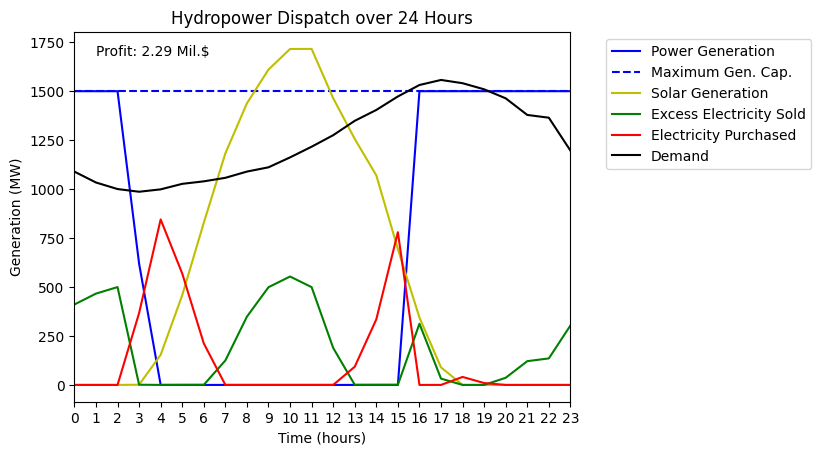

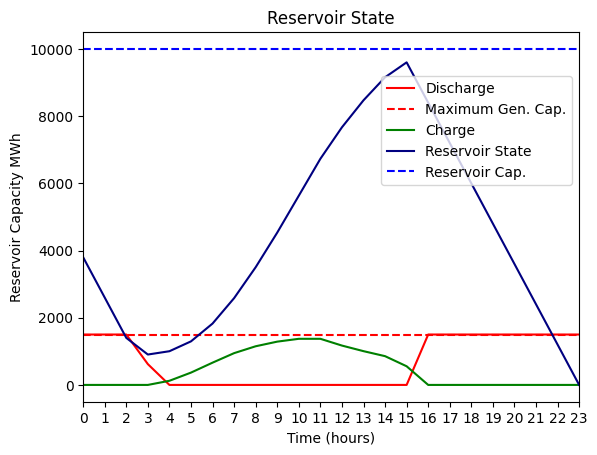

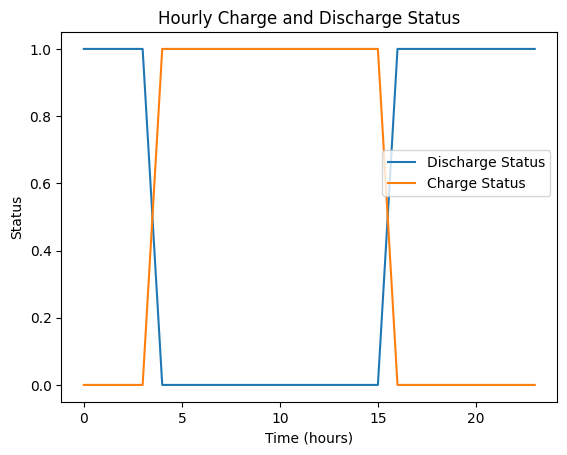

In [316]:
## Plot 1 

# Time axis
t = np.linspace(0, T-1, T) 

plt.plot(t, p.value, label='Power Generation', color='b')
plt.plot(t, PMax*np.ones(T), label = 'Maximum Gen. Cap.', color='b', linestyle='dashed')
plt.plot(t, S*alpha, label='Solar Generation', color='y')
plt.plot(t, x.value, label='Excess Electricity Sold', color='g')
plt.plot(t, g.value, label='Electricity Purchased', color='r')
plt.plot(t, LOAD, label='Demand', color='black')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(t)  
plt.xlabel('Time (hours)')
plt.ylabel('Generation (MW)')
plt.title(f'Hydropower Dispatch over 24 Hours')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.text(1, 1700, f'Profit: {round(obj.value/1e6,2)} Mil.$', verticalalignment='center', horizontalalignment='left')
plt.show()

## Plot 2
plt.plot(t, p.value, label='Discharge', color='r')
plt.plot(t, PMax*np.ones(T), label = 'Maximum Gen. Cap.', color='r', linestyle='dashed')
plt.plot(t, h.value, label='Charge', color='g')
plt.plot(t, e.value, label='Reservoir State', color='navy')
plt.plot(t, Emax*np.ones(T), label = 'Reservoir Cap.', color='b', linestyle='dashed')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(t)
plt.xlabel('Time (hours)')
plt.ylabel('Reservoir Capacity MWh')
plt.title(f'Reservoir State')
plt.legend(loc='upper right', bbox_to_anchor=(1,.9))

# Display the plot
plt.show()

## Plot 3
plt.plot(u.value, label = "Discharge Status")
plt.plot(v.value, label = "Charge Status")
plt.title("Hourly Charge and Discharge Status")
plt.xlabel("Time (hours)")
plt.ylabel('Status')
plt.legend(loc='upper right', bbox_to_anchor=(1, .7))
plt.show()

## Cost Benefit Curve

In [292]:
SolarCap = [1000, 2000, 3000, 4000, 5000] # solar capacity (MW)
PMaxArray = [1000, 1500, 2000, 2500]  # Nameplate capacity (MW)
EMaxArray = [6000, 8000, 10000, 12000, 14000]

scale = 10 
S = 2000 # solar capacity (MW)
PMax = 1500  # Nameplate capacity (MW)
Emax = 10000 #
e0   = Emax/2  # initial reservoir state

In [293]:
cost = []

#for Pmax in PMaxArray:
#for S in SolarCap:
for Emax in EMaxArray: 
    e0 = Emax/2
    
    obj = cp.Maximize(price@(LOAD + x - g))

    # Initialize an empty constraint set
    con_set_1 = []  

    # power balance constraint, supply equals demand
    con_set_1.append(g + S*alpha + p == LOAD + x) 

    for t in range(T):  
            con_set_1.append(e[t] <= Emax)  # maximum pumping limits
            con_set_1.append(e[t] >= 0)  # minimum pumping limits

            con_set_1.append(p[t] <= u[t]*PMax)  # maximum generation limits
            con_set_1.append(p[t] >= 0)  # minimum generation limits

            con_set_1.append(h[t] <= v[t]*eta*alpha[t]*S)  # maximum pumping limits
            con_set_1.append(h[t] >= 0)  # minimum pumping limits

            con_set_1.append(u[t] + v[t] == 1)

            if t==0:    
                con_set_1.append(e[0] == eta*(h[0]-p[0]) + e0)
            else: 
                con_set_1.append(e[t] == eta*(h[t]-p[t]) + e[t-1])


    prob1 = cp.Problem(obj, con_set_1)
    prob1.solve(solver = "GUROBI")
    prob1.solve();
    cost.append(obj.value)

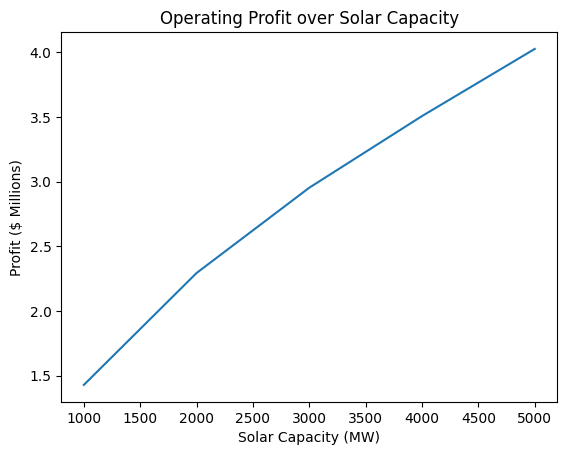

In [282]:
plt.plot(SolarCap, np.array(cost).round()/1e6)
plt.title("Operating Profit over Solar Capacity")
plt.xlabel("Solar Capacity (MW)")
plt.ylabel("Profit ($ Millions)")
plt.show()

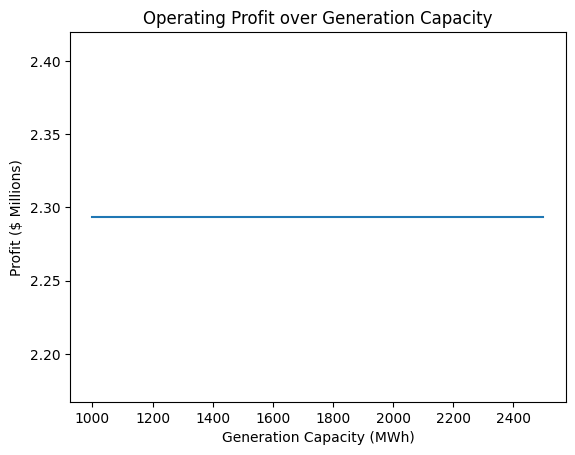

In [288]:
plt.plot(PMaxArray, np.array(cost).round()/1e6)
plt.title("Operating Profit over Generation Capacity")
plt.xlabel("Generation Capacity (MWh)")
plt.ylabel("Profit ($ Millions)")
plt.show()

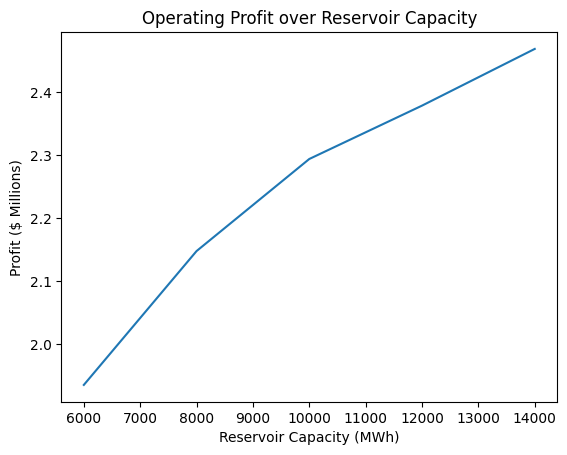

In [294]:
plt.plot(EMaxArray, np.array(cost).round()/1e6)
plt.title("Operating Profit over Reservoir Capacity")
plt.xlabel("Reservoir Capacity (MWh)")
plt.ylabel("Profit ($ Millions)")
plt.show()

In [291]:
cost

[1440768.2558, 1691659.2494, 1934896.3998, 2147302.8062, 1297280.9446]

## Base Case Formulation - 5% Demand Load

$$\max Profit = \sum_{t \in N}\lambda_t(D_t + x_t - g_t)$$
$$g_t + \alpha_tS + p_t = D_t + x_t + h_t$$
$$0 \leq p_t \leq P_{max}$$
$$0 \leq h_t \leq \eta\alpha_tS$$
$$0 \leq e_{U,L,t} \leq \frac{1}{2}E_{max}$$
$$e_{U,t} = e_{U,t-1} + \eta(h_t - p_t)$$ 
$$ e_{L,t} = e_{L,t-1} + \eta(p_t - h_t) $$

In [196]:
eU = cp.Variable((T), nonneg = True)  # upper reservoir state
eL = cp.Variable((T), nonneg = True)  # lower reservoir state
obj = cp.Maximize(price@(LOAD + x - g))

# Initialize an empty constraint set
con_set_1 = []  

# power balance constraint, supply equals demand
con_set_1.append(g + S*alpha + p == LOAD + x + h )

# use a for loop to define the unit constriant over each time period
for t in range(T):  # go through each period
        con_set_1.append(p[t] <= PMax)  # maximum generation limits
        con_set_1.append(p[t] >= 0)  # minimum generation limits
        
        con_set_1.append(h[t] <= eta*alpha[t]*S)  # maximum pumping limits
        con_set_1.append(h[t] >= 0)  # minimum pumping limits
        
        # Assume each reservoir contains half the capacity
        con_set_1.append(eU[t] <= Emax/2)  # maximum pumping limits
        con_set_1.append(eU[t] >= 0)  # minimum pumping limits
        con_set_1.append(eL[t] <= Emax/2)  # maximum pumping limits
        con_set_1.append(eL[t] >= 0)  # minimum pumping limits
        
        if t==0:
            # for the first period, check with initial reservoir status
            con_set_1.append( eU[0] == eta*(h[0]-p[0]) + e0) # upper
            con_set_1.append( eL[0] == eta*(p[0]-h[0]) + e0) # lower
        else:
            con_set_1.append( eU[t] == eta*(h[t]-p[t]) + eU[t-1]) # upper
            con_set_1.append( eL[t] == eta*(p[t]-h[t]) + eL[t-1]) # lower

In [197]:
prob1 = cp.Problem(obj, con_set_1)
prob1.solve(solver = "GUROBI")
prob1.solve();
print("\n Total operating profit: %.1f" % obj.value)


 Total operating profit: 859618.5


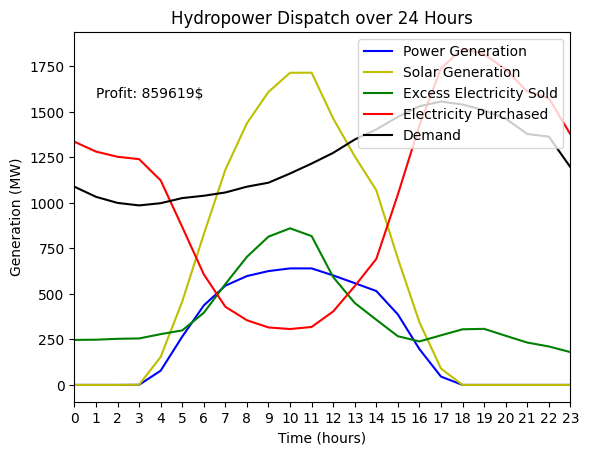

In [198]:
## Plots

# Time axis
t = np.linspace(0, T-1, T) 

plt.plot(t, p.value, label='Power Generation', color='b')
plt.plot(t, S*alpha, label='Solar Generation', color='y')
plt.plot(t, x.value, label='Excess Electricity Sold', color='g')
plt.plot(t, g.value, label='Electricity Purchased', color='r')
plt.plot(t, LOAD, label='Demand', color='black')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(t)  # Only integer x ticks
#plt.ylim(0, max(LOAD)*1.1)
plt.xlabel('Time (hours)')
plt.ylabel('Generation (MW)')
plt.title(f'Hydropower Dispatch over 24 Hours')

# Adding a legend
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.text(1, 1600, f'Profit: {round(obj.value)}$', verticalalignment='center', horizontalalignment='left')

# Display the plot
plt.show()

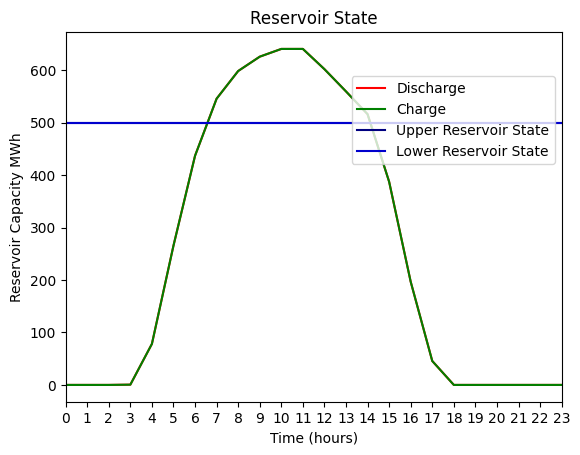

In [199]:
plt.plot(t, p.value, label='Discharge', color='r')
plt.plot(t, h.value, label='Charge', color='g')
plt.plot(t, eU.value, label='Upper Reservoir State', color='navy')
plt.plot(t, eL.value, label='Lower Reservoir State', color='mediumblue')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(t)  # Only integer x ticks
#plt.ylim(0, max(LOAD)*1.1)
plt.xlabel('Time (hours)')
plt.ylabel('Reservoir Capacity MWh')
plt.title(f'Reservoir State')

# Adding a legend
plt.legend(loc='upper right', bbox_to_anchor=(1,.9))

# Display the plot
plt.show()